In [ ]:
!pip install wbdata
!pip install pandas
!pip install datetime
!pip install bayesian-optimization==1.3.0
!pip install scikit-optimize

In [37]:
import wbdata
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import joblib


from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, recall_score,
                             precision_score, accuracy_score, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV


***Préparation des données***

In [3]:
pays = ["AF", "BD", "BJ", "BT", "BF", "BI", "KH", "CM", "TD", "KM", "CI",
                     "DJ", "DM", "ET", "GH", "GD", "KE", "MG", "MW", "ML", "MR",
                     "MZ", "NP", "NE", "RW", "SN", "TG", "UG", "ZM", "ZW","CF", "CG",
        "CD", "GN", "GW", "GY", "HT", "HN", "KI", "KG"]

start_date = datetime.datetime(2008, 1, 1)
end_date = datetime.datetime(2025, 1, 1)

indicators = {
    'DT.DOD.DECT.GN.ZS': 'External_Debt_GDP',
    'DT.TDS.DECT.EX.ZS': 'Debt_Service_Exports',
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth',
    'BN.CAB.XOKA.GD.ZS': 'Current_Account',
    'PA.NUS.FCRF': 'Exchange_Rate',
    'IQ.CPA.TRAN.XQ': 'Corruption_Governance',
    'DT.ODA.ODAT.GN.ZS': 'Net_ODA_received'
}

data = wbdata.get_dataframe(indicators,
                            country=pays,
                            date=(start_date, end_date))

data.reset_index(inplace=True)
data["Year"] = pd.DatetimeIndex(data["date"]).year
data["country_clean"] = data["country"].str.lower().str.strip()

labels_df = pd.read_excel('/content/DEBT_DATA.xlsx')
labels_df["Country_clean"] = labels_df["Country"].str.lower().str.strip()
labels_df["Year"] = labels_df["Year"].astype(int)

data_merged = pd.merge(
    data,
    labels_df,
    left_on=["country_clean", "Year"],
    right_on=["Country_clean", "Year"],
    how="left"
)

data_merged = data_merged.drop(columns=['Country_clean', 'Country', 'date', 'country_clean'])
data_merged = data_merged.rename(columns={'country': 'Country'})

cols = ['Country', 'Year', 'Risk'] + \
       [col for col in data_merged.columns if col not in ['Country', 'Year', 'Risk']]
data_merged = data_merged[cols]

print("Lignes avant merge :", len(data))
print("Lignes après merge :", len(data_merged))
print("Taux de match labels :", data_merged["Risk"].notna().mean())

data_merged = data_merged.dropna(subset=['Risk']).copy()

data_merged.head(150)
data_merged.shape
data_merged.isna().sum()

print(len(data_merged))

Lignes avant merge : 680
Lignes après merge : 680
Taux de match labels : 0.9882352941176471
672


***Option 1 : Suppression des NaN***

In [4]:
data_clean = data_merged.dropna()

n_avant = len(data_merged)
n_apres = len(data_clean)
perte = n_avant - n_apres
pourcentage_perte = (perte / n_avant) * 100

print("\n--- Vérification des valeurs manquantes restantes ---")
missing_check = data_clean.isna().sum()
print(missing_check)
print(len(data_clean))


--- Vérification des valeurs manquantes restantes ---
Country                  0
Year                     0
Risk                     0
External_Debt_GDP        0
Debt_Service_Exports     0
GDP_Growth               0
Current_Account          0
Exchange_Rate            0
Corruption_Governance    0
Net_ODA_received         0
dtype: int64
545


***Option 2 : Traitement des valeurs manquantes***


Valeurs manquantes par année:
Year
2008     10
2009      9
2010      6
2011      8
2012      7
2013      8
2014      6
2015      6
2016      6
2017      8
2018      8
2019      5
2020      4
2021     10
2022     10
2023     15
2024    154
dtype: int64
         Country  Year      Risk  External_Debt_GDP  Debt_Service_Exports  \
16   Afghanistan  2008      HIGH          21.212132              0.402819   
15   Afghanistan  2009      HIGH          20.036725              0.487686   
14   Afghanistan  2010      HIGH          15.333497              0.379800   
13   Afghanistan  2011      HIGH          13.977052              0.323576   
12   Afghanistan  2012      HIGH          12.928160              0.598756   
..           ...   ...       ...                ...                   ...   
667     Zimbabwe  2020  DISTRESS          48.394048             18.681678   
666     Zimbabwe  2021  DISTRESS          51.903280              9.229217   
665     Zimbabwe  2022  DISTRESS          43.180954   

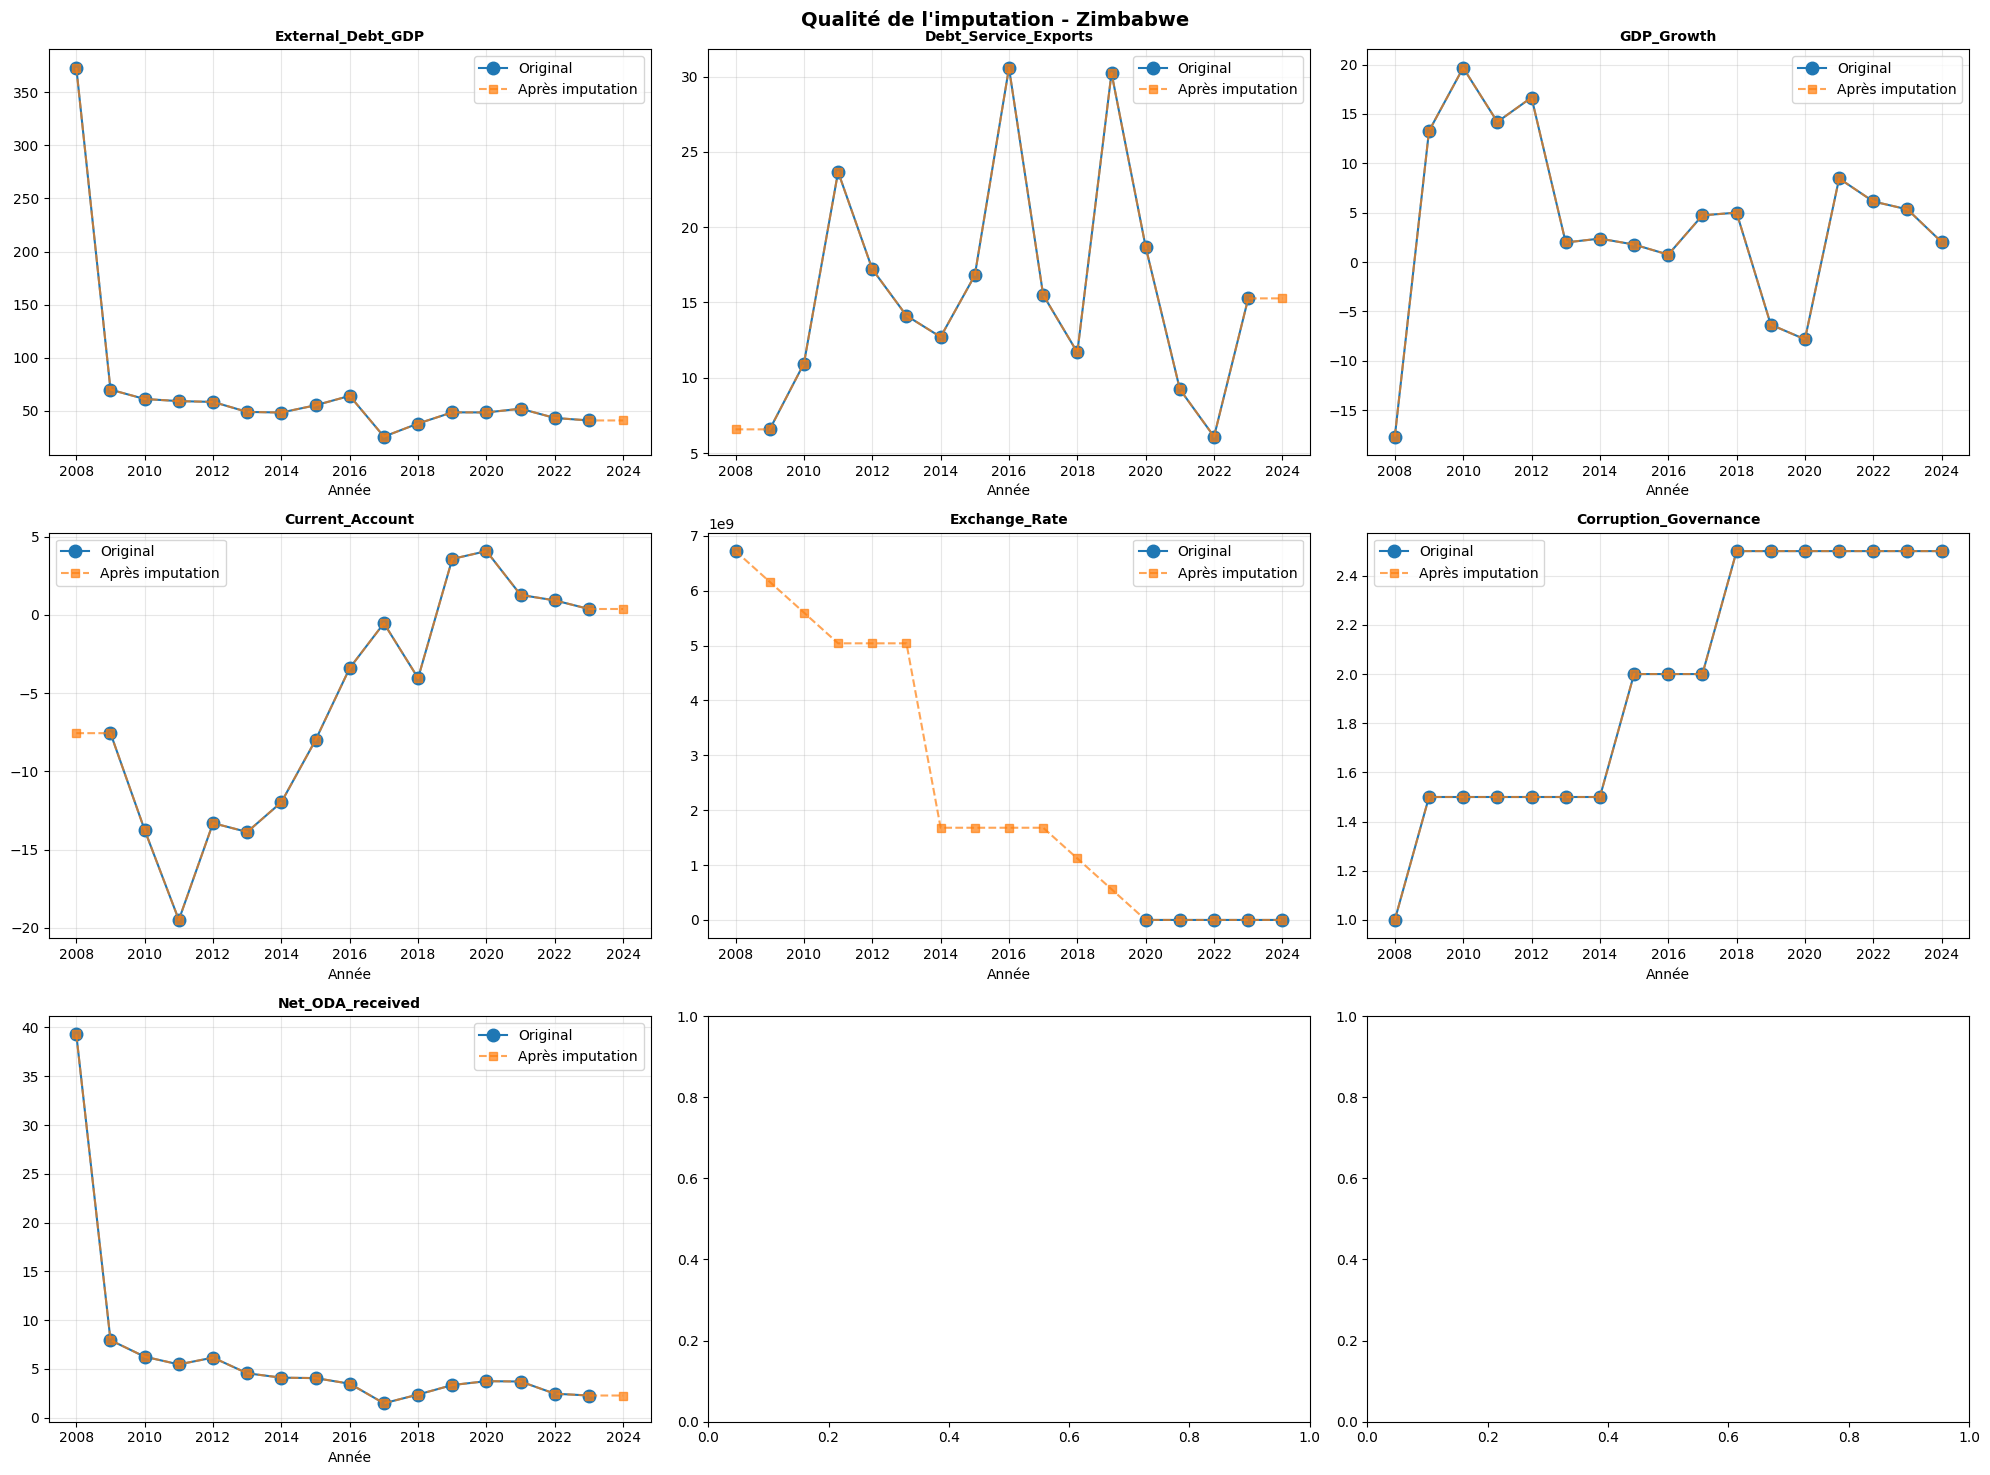

In [5]:
df = data_merged.copy()

missing_by_country = df.groupby('Country').apply(
    lambda x: x.isnull().sum()
).sum(axis=1).sort_values(ascending=False)


missing_by_year = df.groupby('Year').apply(
    lambda x: x.isnull().sum()
).sum(axis=1)

print("\nValeurs manquantes par année:")
print(missing_by_year)

# Interpolation temporelle par pays

numeric_cols = ['External_Debt_GDP', 'Debt_Service_Exports', 'GDP_Growth',
                'Current_Account', 'Exchange_Rate',
                'Corruption_Governance', 'Net_ODA_received']

df = df.sort_values(['Country', 'Year'])

print(df)

for col in numeric_cols:
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both', limit=3)
    )

missing_after_interpolation = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après interpolation temporelle:")
print(missing_after_interpolation)

for col in numeric_cols:
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.fillna(method='ffill', limit=2)
    )
    df[col] = df.groupby('Country')[col].transform(
        lambda x: x.fillna(method='bfill', limit=2)
    )

missing_after_fill = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après forward/backward fill:")
print(missing_after_fill)

# Imputation par médiane du pays

for col in numeric_cols:
    country_median = df.groupby('Country')[col].transform('median')
    df[col] = df[col].fillna(country_median)

missing_after_median = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes après imputation par médiane du pays:")
print(missing_after_median)

# Imputation globale

for col in numeric_cols:
    global_median = df[col].median()
    df[col] = df[col].fillna(global_median)

final_missing = df[numeric_cols].isnull().sum()
print("\nValeurs manquantes finales:")
print(final_missing)


summary = pd.DataFrame({
    'Initial': data_merged[numeric_cols].isnull().sum(),
    'Après_Interpolation': missing_after_interpolation,
    'Après_Fill': missing_after_fill,
    'Après_Médiane': missing_after_median,
    'Final': final_missing
})
summary['Taux_Imputation_%'] = (
    (summary['Initial'] - summary['Final']) / summary['Initial'] * 100
).round(2)

print("\n", summary)



def plot_imputation_quality(original_df, cleaned_df, country='Kenya'):
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    axes = axes.flatten()

    for idx, col in enumerate(numeric_cols):
        orig_data = original_df[original_df['Country'] == country].set_index('Year')[col]
        clean_data = cleaned_df[cleaned_df['Country'] == country].set_index('Year')[col]

        axes[idx].plot(orig_data.index, orig_data.values, 'o-', label='Original', markersize=9)
        axes[idx].plot(clean_data.index, clean_data.values, 's--',
                      label='Après imputation', alpha=0.7, markersize=6)
        axes[idx].set_title(col, fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Année')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle(f'Qualité de l\'imputation - {country}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_imputation_quality(data_merged, df, 'Zimbabwe')

***Distribution des classes***

***Pour option 1***

In [6]:
print("Distribution des classes :")
print(data_clean['Risk'].value_counts())
print("\nProportions :")
print(data_clean['Risk'].value_counts(normalize=True))

Distribution des classes :
Risk
MODERATE    221
HIGH        143
LOW         136
DISTRESS     45
Name: count, dtype: int64

Proportions :
Risk
MODERATE    0.405505
HIGH        0.262385
LOW         0.249541
DISTRESS    0.082569
Name: proportion, dtype: float64


***Pour option 2***

In [7]:
print("Distribution des classes :")
print(df['Risk'].value_counts())
print("\nProportions :")
print(df['Risk'].value_counts(normalize=True))

Distribution des classes :
Risk
MODERATE    261
HIGH        202
LOW         140
DISTRESS     69
Name: count, dtype: int64

Proportions :
Risk
MODERATE    0.388393
HIGH        0.300595
LOW         0.208333
DISTRESS    0.102679
Name: proportion, dtype: float64


***Equilibrage des données***

***Pour option 1***

In [8]:
df_balanced1 = data_clean.copy()

label_encoder1 = LabelEncoder()
df_balanced1['Risk_encoded'] = label_encoder1.fit_transform(df_balanced1['Risk'])

feature_cols = ['External_Debt_GDP', 'Debt_Service_Exports','GDP_Growth',
                'Current_Account', 'Exchange_Rate',
                'Corruption_Governance', 'Net_ODA_received']

train_mask1 = df_balanced1['Year'] <= 2021
test_mask1 = df_balanced1['Year'] > 2021

X_train_raw1 = df_balanced1.loc[train_mask1, feature_cols]
y_train1 = df_balanced1.loc[train_mask1, 'Risk_encoded']

X_test_raw1 = df_balanced1.loc[test_mask1, feature_cols]
y_test1 = df_balanced1.loc[test_mask1, 'Risk_encoded']


scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train_raw1)
X_test_scaled1 = scaler1.transform(X_test_raw1)

X_train_scaled1 = pd.DataFrame(X_train_scaled1, columns=feature_cols, index=X_train_raw1.index)
X_test_scaled1 = pd.DataFrame(X_test_scaled1, columns=feature_cols, index=X_test_raw1.index)


class_counts1 = Counter(y_train1)
max_count1 = max(class_counts1.values())
target_minority1 = max_count1 // 2  # Ratio 1:2

sampling_strategy_dict1 = {}
for class_label, count in class_counts1.items():
    if count < target_minority1:
        sampling_strategy_dict1[class_label] = target_minority1

print(f"Distribution originale Train : {class_counts1}")
print(f"Cible pour les minoritaires : {target_minority1}")

distress_code = label_encoder1.transform(['DISTRESS'])[0] if 'DISTRESS' in label_encoder1.classes_ else -1
if distress_code != -1:
    n_distress = class_counts1[distress_code]
    k = min(5, n_distress - 1)
else:
    k = 5

smote_enn1 = SMOTEENN(
    sampling_strategy=sampling_strategy_dict1,
    smote=SMOTE(k_neighbors=k, random_state=42),
    enn=EditedNearestNeighbours(sampling_strategy='all'),
    random_state=42
)

print("\nApplication de SMOTEENN en cours...")
X_train_resampled1, y_train_resampled1 = smote_enn1.fit_resample(X_train_scaled1, y_train1)

print(f"Nouvelle distribution Train : {Counter(y_train_resampled1)}")


from sklearn.utils.class_weight import compute_class_weight

classes_present1 = np.unique(y_train_resampled1)
weights1 = compute_class_weight(class_weight='balanced', classes=classes_present1, y=y_train_resampled1)
class_weight_dict1 = dict(zip(classes_present1, weights1))

print("\nPoids résiduels (à passer au modèle) :")
for cls, w in class_weight_dict1.items():
    print(f"Classe {label_encoder1.inverse_transform([cls])[0]} : {w:.2f}")


X_train_final = pd.DataFrame(X_train_resampled1, columns=feature_cols)
y_train_final = y_train_resampled1
X_test_final = pd.DataFrame(X_test_scaled1, columns=feature_cols)
y_test_final = y_test1

Distribution originale Train : Counter({3: 198, 2: 128, 1: 122, 0: 35})
Cible pour les minoritaires : 99

Application de SMOTEENN en cours...
Nouvelle distribution Train : Counter({0: 184, 2: 141, 1: 129, 3: 69})

Poids résiduels (à passer au modèle) :
Classe DISTRESS : 0.71
Classe HIGH : 1.01
Classe LOW : 0.93
Classe MODERATE : 1.89


***Pour option 2***

In [9]:
df_balanced = df.copy()

label_encoder = LabelEncoder()
df_balanced['Risk_encoded'] = label_encoder.fit_transform(df_balanced['Risk'])

feature_cols = ['External_Debt_GDP', 'Debt_Service_Exports','GDP_Growth',
                'Current_Account', 'Exchange_Rate',
                'Corruption_Governance', 'Net_ODA_received']

train_mask = df_balanced['Year'] <= 2021
test_mask = df_balanced['Year'] > 2021

X_train_raw = df_balanced.loc[train_mask, feature_cols]
y_train = df_balanced.loc[train_mask, 'Risk_encoded']

X_test_raw = df_balanced.loc[test_mask, feature_cols]
y_test = df_balanced.loc[test_mask, 'Risk_encoded']


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train_raw.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test_raw.index)


class_counts = Counter(y_train)
max_count = max(class_counts.values())
target_minority = max_count // 2  # Ratio 1:2 (Agressif mais souvent nécessaire pour DISTRESS)

sampling_strategy_dict = {}
for class_label, count in class_counts.items():
    if count < target_minority:
        sampling_strategy_dict[class_label] = target_minority

print(f"Distribution originale Train : {class_counts}")
print(f"Cible pour les minoritaires : {target_minority}")

distress_code = label_encoder.transform(['DISTRESS'])[0] if 'DISTRESS' in label_encoder.classes_ else -1
if distress_code != -1:
    n_distress = class_counts[distress_code]
    k = min(5, n_distress - 1)
else:
    k = 5

smote_enn = SMOTEENN(
    sampling_strategy=sampling_strategy_dict,
    smote=SMOTE(k_neighbors=k, random_state=42),
    enn=EditedNearestNeighbours(sampling_strategy='all'),
    random_state=42
)

print("\nApplication de SMOTEENN en cours...")
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Nouvelle distribution Train : {Counter(y_train_resampled)}")


from sklearn.utils.class_weight import compute_class_weight

classes_present = np.unique(y_train_resampled)
weights = compute_class_weight(class_weight='balanced', classes=classes_present, y=y_train_resampled)
class_weight_dict = dict(zip(classes_present, weights))

print("\nPoids résiduels (à passer au modèle) :")
for cls, w in class_weight_dict.items():
    print(f"Classe {label_encoder.inverse_transform([cls])[0]} : {w:.2f}")


X_train_final = pd.DataFrame(X_train_resampled, columns=feature_cols)
y_train_final = y_train_resampled
X_test_final = pd.DataFrame(X_test_scaled, columns=feature_cols)
y_test_final = y_test

Distribution originale Train : Counter({3: 217, 1: 157, 2: 128, 0: 50})
Cible pour les minoritaires : 108

Application de SMOTEENN en cours...
Nouvelle distribution Train : Counter({0: 198, 2: 145, 1: 128, 3: 66})

Poids résiduels (à passer au modèle) :
Classe DISTRESS : 0.68
Classe HIGH : 1.05
Classe LOW : 0.93
Classe MODERATE : 2.03


In [20]:
print(class_counts1, target_minority1)

Counter({3: 198, 2: 128, 1: 122, 0: 35}) 99


======================================================================



---


***1. Régression Logistique Polytomique***


======================================================================

X_train_final shape: (537, 7)
y_train_final distribution: Counter({0: 198, 2: 145, 1: 128, 3: 66})

Class weights calculés (SMOTEENN): {np.int64(0): np.float64(0.678030303030303), np.int64(1): np.float64(1.048828125), np.int64(2): np.float64(0.9258620689655173), np.int64(3): np.float64(2.034090909090909)}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, to

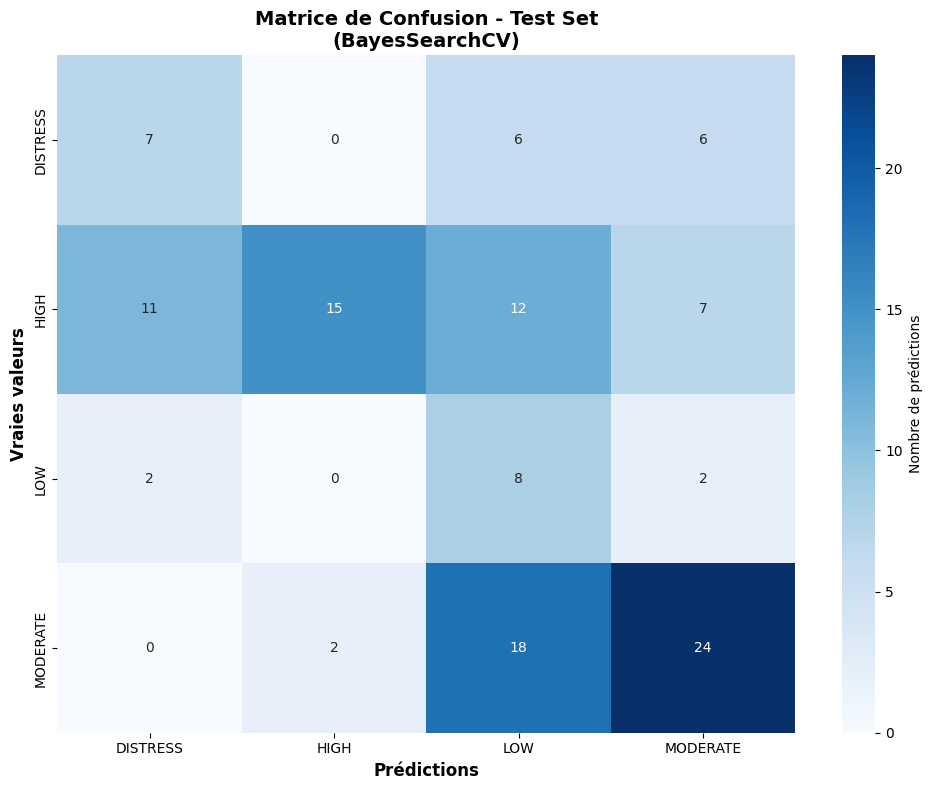


 Classe: DISTRESS
   • Vrais Positifs:  7
   • Faux Positifs:   13
   • Faux Négatifs:   12
   • Precision: 0.3500
   • Recall:    0.3684
   • F1-score:  0.3590
Recall faible (36.84%) - Le modèle rate beaucoup de cas DISTRESS!

 Classe: HIGH
   • Vrais Positifs:  15
   • Faux Positifs:   2
   • Faux Négatifs:   30
   • Precision: 0.8824
   • Recall:    0.3333
   • F1-score:  0.4839

 Classe: LOW
   • Vrais Positifs:  8
   • Faux Positifs:   36
   • Faux Négatifs:   4
   • Precision: 0.1818
   • Recall:    0.6667
   • F1-score:  0.2857

 Classe: MODERATE
   • Vrais Positifs:  24
   • Faux Positifs:   15
   • Faux Négatifs:   20
   • Precision: 0.6154
   • Recall:    0.5455
   • F1-score:  0.5783
DISTRESS            : AUC = 0.6003
HIGH                : AUC = 0.6530
LOW                 : AUC = 0.7230
MODERATE            : AUC = 0.6531


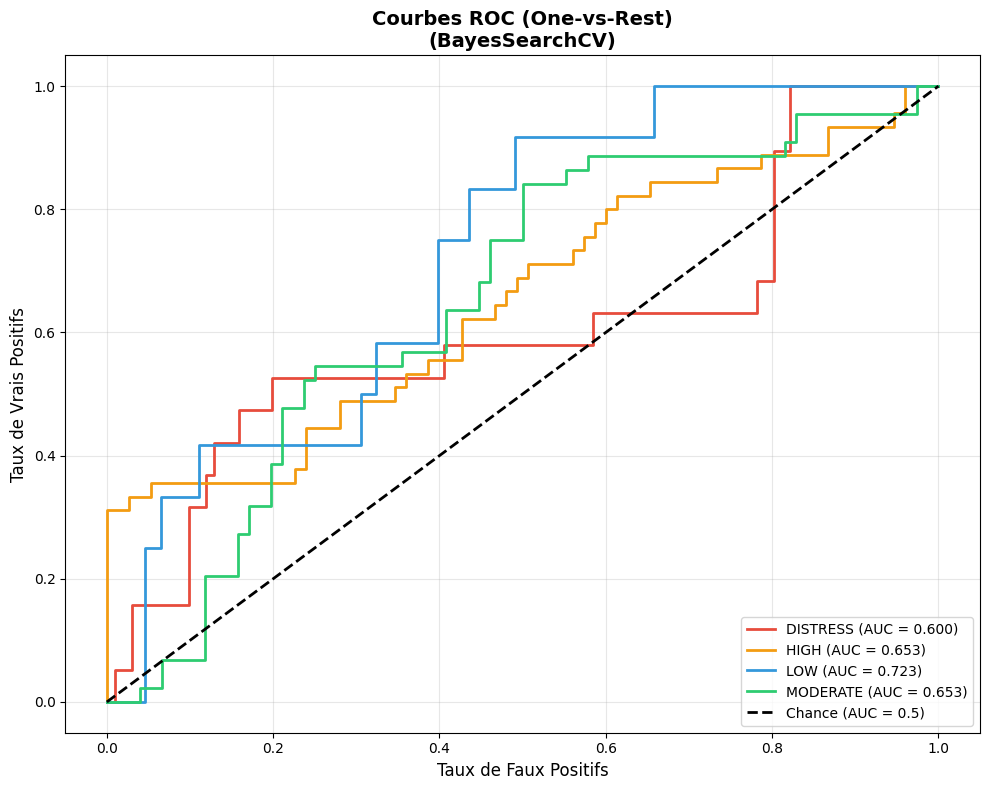


 DISTRESS:
              Feature  Coefficient
        Exchange_Rate     0.694303
    External_Debt_GDP     0.546153
Corruption_Governance    -0.440211
           GDP_Growth    -0.155663
     Net_ODA_received    -0.033129
 Debt_Service_Exports     0.000000
      Current_Account     0.000000

 HIGH:
              Feature  Coefficient
     Net_ODA_received     0.846309
           GDP_Growth    -0.228202
    External_Debt_GDP     0.183709
      Current_Account     0.082685
 Debt_Service_Exports     0.000000
        Exchange_Rate     0.000000
Corruption_Governance     0.000000

 LOW:
              Feature  Coefficient
    External_Debt_GDP    -0.649120
     Net_ODA_received    -0.238695
           GDP_Growth     0.214444
 Debt_Service_Exports    -0.149549
      Current_Account     0.000000
        Exchange_Rate     0.000000
Corruption_Governance     0.000000

 MODERATE:
              Feature  Coefficient
      Current_Account    -0.700167
           GDP_Growth     0.175937
    External_Deb

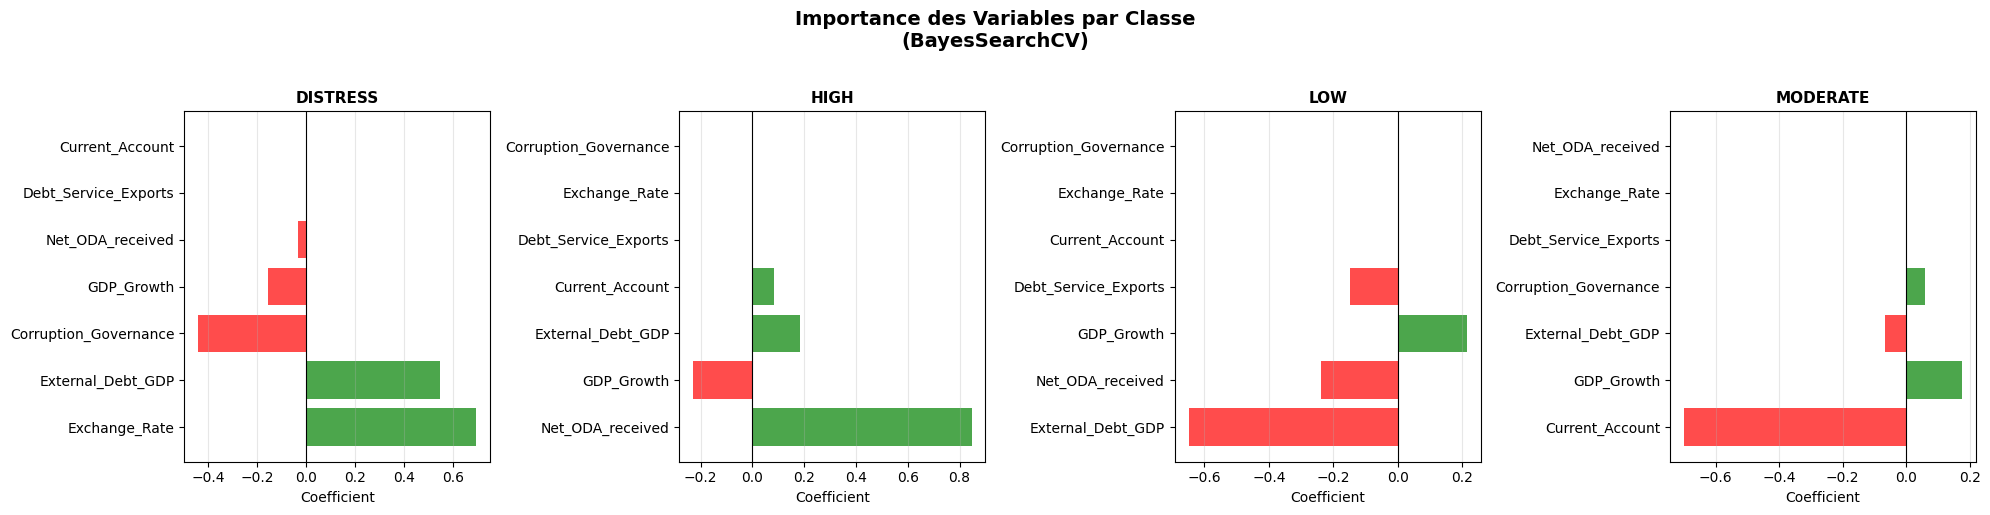

In [34]:
search_spaces = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'l1_ratio': Real(0.0, 1.0),
    'solver': Categorical(['saga']),
    'max_iter': Integer(100, 1000),
    'class_weight': Categorical(['balanced', None])
}

scoring_metric = 'recall_macro'
n_iter = 50
cv_folds = 5

cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final distribution: {Counter(y_train_final)}")
print(f"\nClass weights calculés (SMOTEENN): {class_weight_dict}")

base_model = LogisticRegression(random_state=42, warm_start=True)

bayes_search = BayesSearchCV(
    estimator=base_model,
    search_spaces=search_spaces,
    n_iter=n_iter,
    cv=cv_strategy,
    scoring=scoring_metric,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    return_train_score=True
)

bayes_search.fit(X_train_final, y_train_final)

print(f"\n Meilleur score (CV {scoring_metric}): {bayes_search.best_score_:.4f}")
print(f"\n Meilleurs hyperparamètres trouvés:")
for param, value in bayes_search.best_params_.items():
    print(f"{param:15s}: {value}")



best_params = bayes_search.best_params_.copy()
best_params['class_weight'] = class_weight_dict

model_with_custom_weights = LogisticRegression(**best_params, random_state=42)
model_with_custom_weights.fit(X_train_final, y_train_final)


y_pred_bayes = bayes_search.best_estimator_.predict(X_test_final)
y_pred_proba_bayes = bayes_search.best_estimator_.predict_proba(X_test_final)
recall_bayes = recall_score(y_test_final, y_pred_bayes, average='macro')
f1_bayes = f1_score(y_test_final, y_pred_bayes, average='macro')
print(f"   • Recall macro: {recall_bayes:.4f}")
print(f"   • F1 macro:     {f1_bayes:.4f}")
print(f"   • Accuracy:     {accuracy_score(y_test_final, y_pred_bayes):.4f}")

y_pred_custom = model_with_custom_weights.predict(X_test_final)
y_pred_proba_custom = model_with_custom_weights.predict_proba(X_test_final)
recall_custom = recall_score(y_test_final, y_pred_custom, average='macro')
f1_custom = f1_score(y_test_final, y_pred_custom, average='macro')
print(f"   • Recall macro: {recall_custom:.4f}")
print(f"   • F1 macro:     {f1_custom:.4f}")
print(f"   • Accuracy:     {accuracy_score(y_test_final, y_pred_custom):.4f}")

if recall_custom > recall_bayes:
    best_model = model_with_custom_weights
    y_pred = y_pred_custom
    y_pred_proba = y_pred_proba_custom
    model_type = "Poids personnalisés (SMOTEENN)"
else:
    best_model = bayes_search.best_estimator_
    y_pred = y_pred_bayes
    y_pred_proba = y_pred_proba_bayes
    model_type = "BayesSearchCV"

y_test_labels = label_encoder.inverse_transform(y_test_final)
y_pred_labels = label_encoder.inverse_transform(y_pred)


print(f"   • Accuracy:          {accuracy_score(y_test_final, y_pred):.4f}")
print(f"   • Precision (macro): {precision_score(y_test_final, y_pred, average='macro'):.4f}")
print(f"   • Recall (macro):    {recall_score(y_test_final, y_pred, average='macro'):.4f}")
print(f"   • F1-score (macro):  {f1_score(y_test_final, y_pred, average='macro'):.4f}")


cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Nombre de prédictions'},
            ax=ax)
ax.set_xlabel('Prédictions', fontsize=12, fontweight='bold')
ax.set_ylabel('Vraies valeurs', fontsize=12, fontweight='bold')
ax.set_title(f'Matrice de Confusion - Test Set\n({model_type})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


for i, class_name in enumerate(label_encoder.classes_):
    class_mask_true = (y_test_final == i)
    class_mask_pred = (y_pred == i)

    tp = np.sum(class_mask_true & class_mask_pred)
    fp = np.sum(~class_mask_true & class_mask_pred)
    fn = np.sum(class_mask_true & ~class_mask_pred)
    tn = np.sum(~class_mask_true & ~class_mask_pred)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n Classe: {class_name}")
    print(f"   • Vrais Positifs:  {tp}")
    print(f"   • Faux Positifs:   {fp}")
    print(f"   • Faux Négatifs:   {fn}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-score:  {f1:.4f}")

    if class_name == 'DISTRESS':
        if recall < 0.7:
            print(f"Recall faible ({recall:.2%}) - Le modèle rate beaucoup de cas DISTRESS!")
        else:
            print(f"Recall acceptable ({recall:.2%})")


y_test_bin = label_binarize(y_test_final, classes=range(len(label_encoder.classes_)))
n_classes = len(label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']

for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

    ax.plot(fpr, tpr, color=color, lw=2,
            label=f'{class_name} (AUC = {roc_auc:.3f})')

    print(f"{class_name:20s}: AUC = {roc_auc:.4f}")

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.5)')
ax.set_xlabel('Taux de Faux Positifs', fontsize=12)
ax.set_ylabel('Taux de Vrais Positifs', fontsize=12)
ax.set_title(f'Courbes ROC (One-vs-Rest)\n({model_type})',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


coefficients = best_model.coef_

fig, axes = plt.subplots(1, n_classes, figsize=(20, 5))
if n_classes == 1:
    axes = [axes]

for i, (class_name, ax) in enumerate(zip(label_encoder.classes_, axes)):
    coef_df = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Coefficient': coefficients[i]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print(f"\n {class_name}:")
    print(coef_df.to_string(index=False))

    colors_bar = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_bar, alpha=0.7)
    ax.set_xlabel('Coefficient', fontsize=10)
    ax.set_title(f'{class_name}', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

plt.suptitle(f'Importance des Variables par Classe\n({model_type})',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

======================================================================

***2. Régression Logistique Binomiale***

======================================================================

C bon
   Gap Train-CV: 0.0001C bon

 Meilleur modèle: class_weight='custom'
 Meilleur score (CV): 0.9663
 Gap Train-CV: 0.0001

 Meilleurs hyperparamètres:
C: 4.678860424711244
l1_ratio: 0.9393697376027718
max_iter: 494
penalty: l1
solver: saga
 Seuil   Recall  Precision       F1  Coût_Total
  0.25 1.000000   0.551724 0.711111          52
  0.30 1.000000   0.551724 0.711111          52
  0.20 1.000000   0.547009 0.707182          53
  0.35 0.984375   0.547826 0.703911          62
  0.40 0.968750   0.543860 0.696629          72
  0.45 0.953125   0.544643 0.693182          81
  0.55 0.937500   0.555556 0.697674          88
  0.50 0.937500   0.550459 0.693642          89
  0.60 0.906250   0.557692 0.690476         106
  0.65 0.890625   0.564356 0.690909         114

 Meilleur seuil (coût minimal): 0.25
   Coût total: 52
   Recall: 100.00%
   Precision: 55.17%
   F1-Score: 71.11%


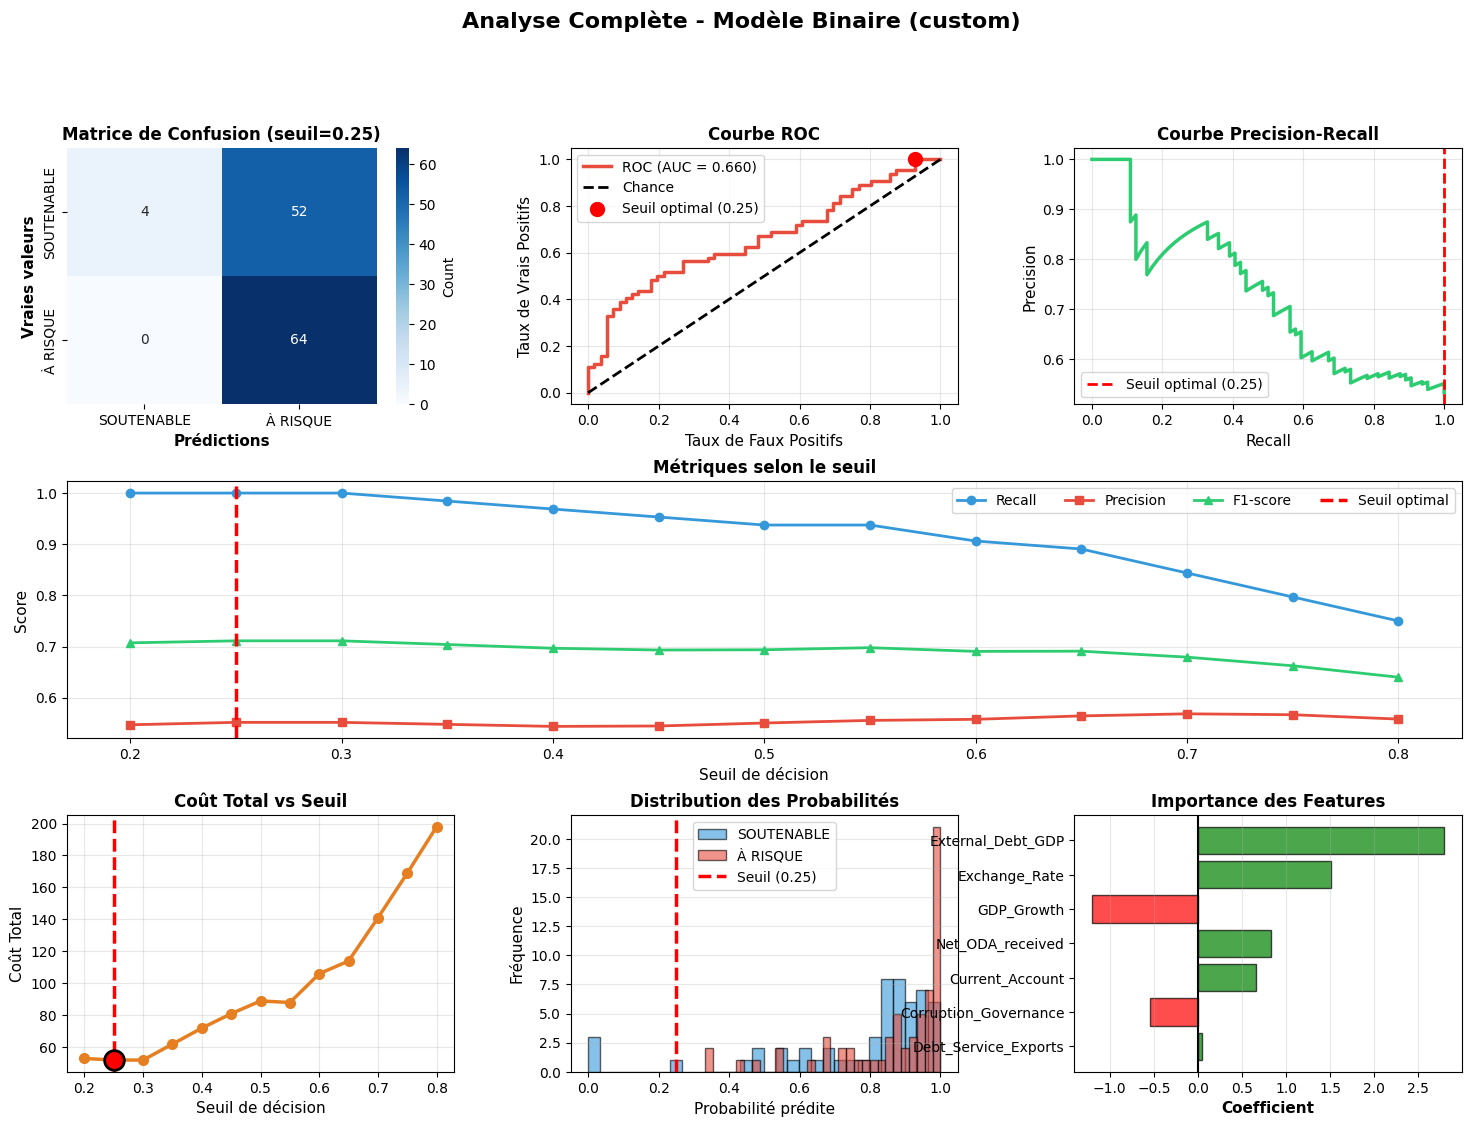


 Performance avec seuil optimal (0.25):
              precision    recall  f1-score   support

  SOUTENABLE     1.0000    0.0714    0.1333        56
    À RISQUE     0.5517    1.0000    0.7111        64

    accuracy                         0.5667       120
   macro avg     0.7759    0.5357    0.4222       120
weighted avg     0.7609    0.5667    0.4415       120

Vrais Positifs (À RISQUE bien détecté): 64
Faux Négatifs (À RISQUE raté): 0 → Coût = 0
Faux Positifs (Fausse alerte): 52 → Coût = 52
Vrais Négatifs (SOUTENABLE bien détecté): 4

 COÛT TOTAL: 52

 COMPARAISON DES STRATÉGIES:
Stratégie 'balanced':
Score CV: 0.8006
Gap: 0.0006
Stratégie 'custom weights':
Score CV: 0.9663
Gap: 0.0001

 Stratégie retenue: custom
              Feature  Coefficient
    External_Debt_GDP     2.795260
        Exchange_Rate     1.506111
           GDP_Growth    -1.202662
     Net_ODA_received     0.828531
      Current_Account     0.664777
Corruption_Governance    -0.548142
 Debt_Service_Exports     0

In [36]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) | (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) | (y_test_final == high_label)).astype(int)

ratio = (~y_train_binary.astype(bool)).sum() / y_train_binary.sum()

cost_fn = 10
cost_fp = 1

n_at_risque = y_train_binary.sum()
n_soutenable = (~y_train_binary.astype(bool)).sum()
n_total = len(y_train_binary)

weight_at_risque = (cost_fn / (cost_fn + cost_fp)) * (n_total / n_at_risque)
weight_soutenable = (cost_fp / (cost_fn + cost_fp)) * (n_total / n_soutenable)

total_weight = weight_at_risque + weight_soutenable
weight_at_risque = weight_at_risque / (total_weight / 2)
weight_soutenable = weight_soutenable / (total_weight / 2)

class_weight_custom = {1: weight_at_risque, 0: weight_soutenable}

def cost_sensitive_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        return 0
    total_cost = fn * cost_fn + fp * cost_fp
    max_cost = len(y_true) * max(cost_fn, cost_fp)
    return 1 - (total_cost / max_cost)

cost_scorer = make_scorer(cost_sensitive_score)


search_spaces_binary = {
    'C': Real(0.001, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2', 'elasticnet']),
    'l1_ratio': Real(0.0, 1.0),
    'solver': Categorical(['saga']),
    'max_iter': Integer(200, 2000),
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model_balanced = LogisticRegression(
    random_state=42,
    warm_start=True,
    class_weight='balanced'
)

bayes_search_balanced = BayesSearchCV(
    estimator=model_balanced,
    search_spaces=search_spaces_binary,
    n_iter=30,
    cv=cv_strategy,
    scoring=cost_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_search_balanced.fit(X_train_final, y_train_binary)

cv_results_balanced = pd.DataFrame(bayes_search_balanced.cv_results_)
best_idx_balanced = bayes_search_balanced.best_index_
train_score_balanced = cv_results_balanced.loc[best_idx_balanced, 'mean_train_score']
test_score_balanced = cv_results_balanced.loc[best_idx_balanced, 'mean_test_score']
gap_balanced = train_score_balanced - test_score_balanced

if gap_balanced < 0.05:
    print("C bon")
elif gap_balanced < 0.10:
    print("Rsique d'overfitting")
else:
    print("Overfitting")


model_custom = LogisticRegression(
    random_state=42,
    warm_start=True,
    class_weight=class_weight_custom
)

bayes_search_custom = BayesSearchCV(
    estimator=model_custom,
    search_spaces=search_spaces_binary,
    n_iter=30,
    cv=cv_strategy,
    scoring=cost_scorer,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_search_custom.fit(X_train_final, y_train_binary)

cv_results_custom = pd.DataFrame(bayes_search_custom.cv_results_)
best_idx_custom = bayes_search_custom.best_index_
train_score_custom = cv_results_custom.loc[best_idx_custom, 'mean_train_score']
test_score_custom = cv_results_custom.loc[best_idx_custom, 'mean_test_score']
gap_custom = train_score_custom - test_score_custom

print(f"   Gap Train-CV: {gap_custom:.4f}", end="")
if gap_custom < 0.05:
    print("C bon")
elif gap_custom < 0.10:
    print("Overfitting")
else:
    print("Overfitting")


models_comparison = {
    'balanced': {
        'model': bayes_search_balanced,
        'score': bayes_search_balanced.best_score_,
        'gap': gap_balanced
    },
    'custom': {
        'model': bayes_search_custom,
        'score': bayes_search_custom.best_score_,
        'gap': gap_custom
    }
}

best_choice = None
best_score_val = -np.inf

for name, info in models_comparison.items():
    adjusted_score = info['score'] - (info['gap'] * 2)
    if adjusted_score > best_score_val:
        best_score_val = adjusted_score
        best_choice = name

weight_type = best_choice
bayes_search_binary = models_comparison[best_choice]['model']

print(f"\n Meilleur modèle: class_weight='{weight_type}'")
print(f" Meilleur score (CV): {bayes_search_binary.best_score_:.4f}")
print(f" Gap Train-CV: {models_comparison[best_choice]['gap']:.4f}")
print(f"\n Meilleurs hyperparamètres:")
for param, value in bayes_search_binary.best_params_.items():
    print(f"{param}: {value}")

best_model_binary = bayes_search_binary.best_estimator_



y_pred_proba_binary = best_model_binary.predict_proba(X_test_final)[:, 1]

thresholds_to_test = np.arange(0.20, 0.80, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba_binary >= threshold).astype(int)

    cm = confusion_matrix(y_test_binary, y_pred_threshold)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        continue

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    total_cost = fn * cost_fn + fp * cost_fp

    results.append({
        'Seuil': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Coût_Total': total_cost
    })

results_df = pd.DataFrame(results)

top_results = results_df.nsmallest(10, 'Coût_Total')
print(top_results[['Seuil', 'Recall', 'Precision', 'F1', 'Coût_Total']].to_string(index=False))

best_threshold_idx = results_df['Coût_Total'].idxmin()
best_threshold = results_df.loc[best_threshold_idx, 'Seuil']

print(f"\n Meilleur seuil (coût minimal): {best_threshold:.2f}")
print(f"   Coût total: {results_df.loc[best_threshold_idx, 'Coût_Total']:.0f}")
print(f"   Recall: {results_df.loc[best_threshold_idx, 'Recall']:.2%}")
print(f"   Precision: {results_df.loc[best_threshold_idx, 'Precision']:.2%}")
print(f"   F1-Score: {results_df.loc[best_threshold_idx, 'F1']:.2%}")

y_pred_binary_final = (y_pred_proba_binary >= best_threshold).astype(int)



fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test_binary, y_pred_binary_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SOUTENABLE', 'À RISQUE'],
            yticklabels=['SOUTENABLE', 'À RISQUE'],
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Prédictions', fontsize=11, fontweight='bold')
ax1.set_ylabel('Vraies valeurs', fontsize=11, fontweight='bold')
ax1.set_title(f'Matrice de Confusion (seuil={best_threshold:.2f})',
              fontsize=12, fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, thresholds_roc = roc_curve(y_test_binary, y_pred_proba_binary)
roc_auc = roc_auc_score(y_test_binary, y_pred_proba_binary)

ax2.plot(fpr, tpr, color='#e74c3c', lw=2.5, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

idx_threshold = np.argmin(np.abs(thresholds_roc - best_threshold))
ax2.scatter([fpr[idx_threshold]], [tpr[idx_threshold]],
           color='red', s=100, zorder=5, label=f'Seuil optimal ({best_threshold:.2f})')
ax2.set_xlabel('Taux de Faux Positifs', fontsize=11)
ax2.set_ylabel('Taux de Vrais Positifs', fontsize=11)
ax2.set_title('Courbe ROC', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
precision_curve, recall_curve, _ = precision_recall_curve(y_test_binary, y_pred_proba_binary)

ax3.plot(recall_curve, precision_curve, color='#2ecc71', lw=2.5)
ax3.axvline(x=results_df.loc[best_threshold_idx, 'Recall'],
           color='red', linestyle='--', lw=2, label=f'Seuil optimal ({best_threshold:.2f})')
ax3.set_xlabel('Recall', fontsize=11)
ax3.set_ylabel('Precision', fontsize=11)
ax3.set_title('Courbe Precision-Recall', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, :])
ax4.plot(results_df['Seuil'], results_df['Recall'], 'o-',
         label='Recall', lw=2, markersize=6, color='#3498db')
ax4.plot(results_df['Seuil'], results_df['Precision'], 's-',
         label='Precision', lw=2, markersize=6, color='#e74c3c')
ax4.plot(results_df['Seuil'], results_df['F1'], '^-',
         label='F1-score', lw=2, markersize=6, color='#2ecc71')
ax4.axvline(x=best_threshold, color='red', linestyle='--',
           label=f'Seuil optimal', lw=2.5)
ax4.set_xlabel('Seuil de décision', fontsize=11)
ax4.set_ylabel('Score', fontsize=11)
ax4.set_title('Métriques selon le seuil', fontsize=12, fontweight='bold')
ax4.legend(loc='best', ncol=4)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(results_df['Seuil'], results_df['Coût_Total'], 'o-',
         lw=2.5, markersize=7, color='#e67e22')
ax5.axvline(x=best_threshold, color='red', linestyle='--', lw=2.5)
ax5.scatter([best_threshold], [results_df.loc[best_threshold_idx, 'Coût_Total']],
           color='red', s=200, zorder=5, edgecolors='black', linewidths=2)
ax5.set_xlabel('Seuil de décision', fontsize=11)
ax5.set_ylabel('Coût Total', fontsize=11)
ax5.set_title('Coût Total vs Seuil', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_pred_proba_binary[y_test_binary == 0], bins=30, alpha=0.6,
         label='SOUTENABLE', color='#3498db', edgecolor='black')
ax6.hist(y_pred_proba_binary[y_test_binary == 1], bins=30, alpha=0.6,
         label='À RISQUE', color='#e74c3c', edgecolor='black')
ax6.axvline(x=best_threshold, color='red', linestyle='--', lw=2.5,
           label=f'Seuil ({best_threshold:.2f})')
ax6.set_xlabel('Probabilité prédite', fontsize=11)
ax6.set_ylabel('Fréquence', fontsize=11)
ax6.set_title('Distribution des Probabilités', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

ax7 = fig.add_subplot(gs[2, 2])
coef_binary = best_model_binary.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': coef_binary,
    'Abs_Coefficient': np.abs(coef_binary)
}).sort_values('Abs_Coefficient', ascending=True)

colors_bar = ['red' if x < 0 else 'green' for x in feature_importance['Coefficient']]
ax7.barh(feature_importance['Feature'], feature_importance['Coefficient'],
        color=colors_bar, alpha=0.7, edgecolor='black')
ax7.set_xlabel('Coefficient', fontsize=11, fontweight='bold')
ax7.set_title('Importance des Features', fontsize=12, fontweight='bold')
ax7.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
ax7.grid(axis='x', alpha=0.3)

plt.suptitle(f'Analyse Complète - Modèle Binaire ({weight_type})',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


print(f"\n Performance avec seuil optimal ({best_threshold:.2f}):")
print(classification_report(y_test_binary, y_pred_binary_final,
                           target_names=['SOUTENABLE', 'À RISQUE'], digits=4))


tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary_final).ravel()
print(f"Vrais Positifs (À RISQUE bien détecté): {tp}")
print(f"Faux Négatifs (À RISQUE raté): {fn} → Coût = {fn * cost_fn}")
print(f"Faux Positifs (Fausse alerte): {fp} → Coût = {fp * cost_fp}")
print(f"Vrais Négatifs (SOUTENABLE bien détecté): {tn}")
print(f"\n COÛT TOTAL: {fn * cost_fn + fp * cost_fp}")

print(f"\n COMPARAISON DES STRATÉGIES:")
print(f"Stratégie 'balanced':")
print(f"Score CV: {bayes_search_balanced.best_score_:.4f}")
print(f"Gap: {gap_balanced:.4f}")
print(f"Stratégie 'custom weights':")
print(f"Score CV: {bayes_search_custom.best_score_:.4f}")
print(f"Gap: {gap_custom:.4f}")
print(f"\n Stratégie retenue: {weight_type}")

feature_importance_sorted = feature_importance.sort_values('Abs_Coefficient', ascending=False)
print(feature_importance_sorted[['Feature', 'Coefficient']].to_string(index=False))

======================================================================

***3. LightGBM***

======================================================================

À RISQUE:    326 (60.7%)
SOUTENABLE:  211 (39.3%)
À RISQUE:    64 (53.3%)
SOUTENABLE:  56 (46.7%)

 Shift réduit: 7.4% (vs 21-24% en multiclasse)
scale_pos_weight: 0.65
Modèle entraîné (200 arbres)
              precision    recall  f1-score   support

  SOUTENABLE      0.894     0.924     0.909       211
    À RISQUE      0.950     0.929     0.940       326

    accuracy                          0.927       537
   macro avg      0.922     0.927     0.924       537
weighted avg      0.928     0.927     0.928       537

              precision    recall  f1-score   support

  SOUTENABLE      0.667     0.714     0.690        56
    À RISQUE      0.733     0.688     0.710        64

    accuracy                          0.700       120
   macro avg      0.700     0.701     0.700       120
weighted avg      0.702     0.700     0.700       120

F1 Train:       0.9395
F1 Test:        0.7097
Gap:            0.2299Overfitting persistant
Vrais Positifs (À RISQUE détecté):  44
Faux Négatifs (À R

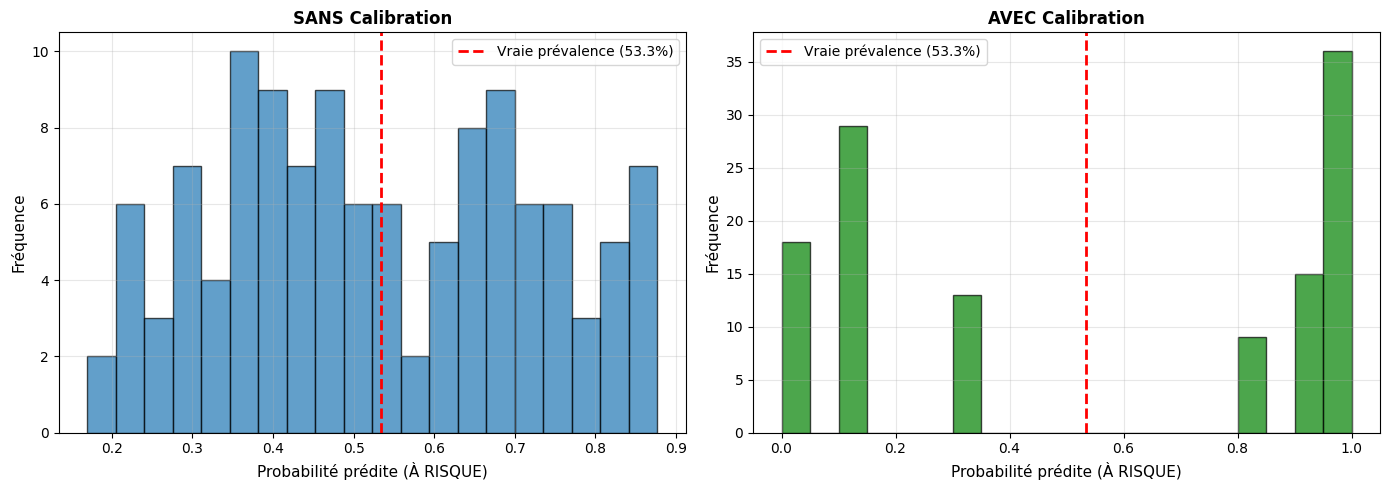


 Seuil optimal: 0.20
F1 au seuil ~0.50: 0.7097
F1 au seuil 0.20: 0.7299
Gain:             +0.0202


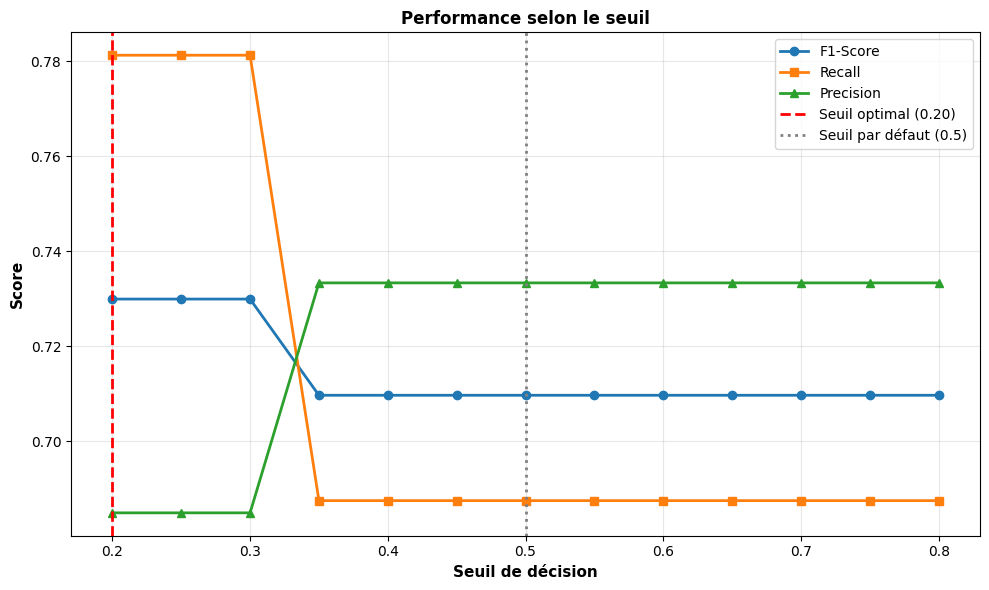


 PERFORMANCE FINALE (seuil = 0.20):
              precision    recall  f1-score   support

  SOUTENABLE      0.702     0.589     0.641        56
    À RISQUE      0.685     0.781     0.730        64

    accuracy                          0.692       120
   macro avg      0.694     0.685     0.685       120
weighted avg      0.693     0.692     0.688       120

              feature  importance
Corruption_Governance         145
    External_Debt_GDP         121
 Debt_Service_Exports         114
     Net_ODA_received          99
        Exchange_Rate          87
           GDP_Growth          65
      Current_Account          45

   F1-Score Test:     0.7097
   Recall À RISQUE:   68.8%
   Gap Train-Test:    0.2299


In [39]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) |
                  (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) |
                 (y_test_final == high_label)).astype(int)


print(f"À RISQUE:    {y_train_binary.sum()} ({y_train_binary.mean():.1%})")
print(f"SOUTENABLE:  {(~y_train_binary.astype(bool)).sum()} ({(~y_train_binary.astype(bool)).mean():.1%})")

print(f"À RISQUE:    {y_test_binary.sum()} ({y_test_binary.mean():.1%})")
print(f"SOUTENABLE:  {(~y_test_binary.astype(bool)).sum()} ({(~y_test_binary.astype(bool)).mean():.1%})")

shift_binary = abs(y_train_binary.mean() - y_test_binary.mean()) * 100
print(f"\n Shift réduit: {shift_binary:.1f}% (vs 21-24% en multiclasse)")


n_neg = (~y_train_binary.astype(bool)).sum()
n_pos = y_train_binary.sum()
scale_pos_weight = n_neg / n_pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

lgbm_binary = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    verbosity=-1,
    random_state=42,
    n_jobs=-1,
    num_leaves=15,
    max_depth=3,
    min_child_samples=20,
    min_child_weight=1.0,
    lambda_l1=1.0,
    lambda_l2=10.0,
    min_gain_to_split=0.5,
    bagging_fraction=0.56,
    bagging_freq=1,
    feature_fraction=0.6,
    learning_rate=0.02,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    max_bin=63
)

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final, y_train_binary,
    test_size=0.25, random_state=42, stratify=y_train_binary
)

lgbm_binary.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=15, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)

print(f"Modèle entraîné ({lgbm_binary.best_iteration_} arbres)")


calibrated_model = CalibratedClassifierCV(
    lgbm_binary,
    method='isotonic',
    cv='prefit'
)

calibrated_model.fit(X_val, y_val)


y_train_pred_binary = calibrated_model.predict(X_train_final)
y_test_pred_binary = calibrated_model.predict(X_test_final)
y_test_proba_binary = calibrated_model.predict_proba(X_test_final)[:, 1]


print(classification_report(y_train_binary, y_train_pred_binary,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))


print(classification_report(y_test_binary, y_test_pred_binary,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))

train_f1 = f1_score(y_train_binary, y_train_pred_binary)
test_f1 = f1_score(y_test_binary, y_test_pred_binary)
gap = train_f1 - test_f1

print(f"F1 Train:       {train_f1:.4f}")
print(f"F1 Test:        {test_f1:.4f}")
print(f"Gap:            {gap:.4f}", end="")

if gap < 0.10:
    print("Excellent")
elif gap < 0.20:
    print("Acceptable")
else:
    print("Overfitting persistant")

cm = confusion_matrix(y_test_binary, y_test_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"Vrais Positifs (À RISQUE détecté):  {tp}")
print(f"Faux Négatifs (À RISQUE raté):      {fn}")
print(f"Faux Positifs (Fausse alerte):      {fp}")
print(f"Vrais Négatifs (SOUTENABLE ok):     {tn}")

recall_at_risk = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_at_risk = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"Recall:    {recall_at_risk:.1%} (% de crises détectées)")
print(f"Precision: {precision_at_risk:.1%} (% d'alertes correctes)")

if recall_at_risk >= 0.70:
    print("Bonne détection des crises")
elif recall_at_risk >= 0.60:
    print("Détection acceptable mais perfectible")
else:
    print("Trop de crises ratées")


y_test_pred_uncalib = lgbm_binary.predict(X_test_final)
y_test_proba_uncalib = lgbm_binary.predict_proba(X_test_final)[:, 1]

f1_uncalib = f1_score(y_test_binary, y_test_pred_uncalib)
f1_calib = f1_score(y_test_binary, y_test_pred_binary)

print(f"Sans calibration: {f1_uncalib:.4f}")
print(f"Avec calibration: {f1_calib:.4f}")
print(f"Gain:             {f1_calib - f1_uncalib:+.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_test_proba_uncalib, bins=20, alpha=0.7, edgecolor='black')
axes[0].axvline(y_test_binary.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Vraie prévalence ({y_test_binary.mean():.1%})')
axes[0].set_xlabel('Probabilité prédite (À RISQUE)', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('SANS Calibration', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(y_test_proba_binary, bins=20, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(y_test_binary.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Vraie prévalence ({y_test_binary.mean():.1%})')
axes[1].set_xlabel('Probabilité prédite (À RISQUE)', fontsize=11)
axes[1].set_ylabel('Fréquence', fontsize=11)
axes[1].set_title('AVEC Calibration', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


thresholds_to_test = np.arange(0.2, 0.8, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_test_proba_binary >= threshold).astype(int)

    precision = precision_score(y_test_binary, y_pred_thresh) if y_pred_thresh.sum() > 0 else 0
    recall = recall_score(y_test_binary, y_pred_thresh)
    f1 = f1_score(y_test_binary, y_pred_thresh)

    results.append({
        'Seuil': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results)
best_threshold = results_df.loc[results_df['F1'].idxmax(), 'Seuil']

print(f"\n Seuil optimal: {best_threshold:.2f}")

seuil_050 = results_df.iloc[(results_df['Seuil'] - 0.50).abs().argsort()[:1]]
f1_at_050 = seuil_050['F1'].values[0] if len(seuil_050) > 0 else 0

print(f"F1 au seuil ~0.50: {f1_at_050:.4f}")
print(f"F1 au seuil {best_threshold:.2f}: {results_df['F1'].max():.4f}")
print(f"Gain:             {results_df['F1'].max() - f1_at_050:+.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['Seuil'], results_df['F1'], 'o-', label='F1-Score', linewidth=2)
ax.plot(results_df['Seuil'], results_df['Recall'], 's-', label='Recall', linewidth=2)
ax.plot(results_df['Seuil'], results_df['Precision'], '^-', label='Precision', linewidth=2)
ax.axvline(best_threshold, color='red', linestyle='--',
           label=f'Seuil optimal ({best_threshold:.2f})', linewidth=2)
ax.axvline(0.5, color='gray', linestyle=':', label='Seuil par défaut (0.5)', linewidth=2)
ax.set_xlabel('Seuil de décision', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Performance selon le seuil', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_test_pred_optimal = (y_test_proba_binary >= best_threshold).astype(int)

print(f"\n PERFORMANCE FINALE (seuil = {best_threshold:.2f}):")
print(classification_report(y_test_binary, y_test_pred_optimal,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))


feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_binary.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))


joblib.dump(calibrated_model, 'lgbm_binary_calibrated.pkl')
joblib.dump(best_threshold, 'lgbm_optimal_threshold.pkl')
joblib.dump({
    'train_f1': train_f1,
    'test_f1': test_f1,
    'gap': gap,
    'recall_at_risk': recall_at_risk,
    'best_threshold': best_threshold
}, 'lgbm_binary_metrics.pkl')



print(f"""
   F1-Score Test:     {test_f1:.4f}
   Recall À RISQUE:   {recall_at_risk:.1%}
   Gap Train-Test:    {gap:.4f}""")

======================================================================

***4. XGBoost***

======================================================================

In [43]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) |
                  (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) |
                 (y_test_final == high_label)).astype(int)

print(f"À RISQUE: {y_train_binary.sum()} ({y_train_binary.mean():.1%})")
print(f"SOUTENABLE: {(~y_train_binary.astype(bool)).sum()} ({(~y_train_binary.astype(bool)).mean():.1%})")

print(f"À RISQUE: {y_test_binary.sum()} ({y_test_binary.mean():.1%})")
print(f"SOUTENABLE: {(~y_test_binary.astype(bool)).sum()} ({(~y_test_binary.astype(bool)).mean():.1%})")

shift_binary = abs(y_train_binary.mean() - y_test_binary.mean()) * 100
print(f"\n Shift Train-Test: {shift_binary:.1f}%")

À RISQUE: 326 (60.7%)
SOUTENABLE: 211 (39.3%)
À RISQUE: 64 (53.3%)
SOUTENABLE: 56 (46.7%)

 Shift Train-Test: 7.4%


In [42]:
# ======================================================================
# STRATÉGIE 1 : RANDOM FOREST
# ======================================================================

In [44]:
search_spaces_rf = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(10, 30),
    'min_samples_leaf': Integer(5, 15),
    'max_features': Categorical(['sqrt', 'log2']),
    'class_weight': Categorical(['balanced', 'balanced_subsample', None])
}

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

bayes_rf = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_spaces_rf,
    n_iter=25,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_rf.fit(X_train_final, y_train_binary)

cv_results_rf = pd.DataFrame(bayes_rf.cv_results_)
best_idx_rf = bayes_rf.best_index_
train_score_rf = cv_results_rf.loc[best_idx_rf, 'mean_train_score']
test_score_cv_rf = cv_results_rf.loc[best_idx_rf, 'mean_test_score']
gap_rf = train_score_rf - test_score_cv_rf

print(f"   Score CV (F1): {bayes_rf.best_score_:.4f}")
print(f"   Train: {train_score_rf:.4f}")
print(f"   Test (CV): {test_score_cv_rf:.4f}")
print(f"   Gap Train-CV: {gap_rf:.4f}", end="")
if gap_rf < 0.05:
    print("Excellent")
elif gap_rf < 0.10:
    print("Acceptable")
else:
    print("Overfitting")

print(f"\n Meilleurs hyperparamètres RF:")
for param, value in bayes_rf.best_params_.items():
    print(f"{param}: {value}")

   Score CV (F1): 0.9649
   Train: 0.9943
   Test (CV): 0.9649
   Gap Train-CV: 0.0293Excellent

 Meilleurs hyperparamètres RF:
class_weight: None
max_depth: 10
max_features: log2
min_samples_leaf: 5
min_samples_split: 10
n_estimators: 200


In [45]:
# ======================================================================
# STRATÉGIE 2 : XGBOOST
# ======================================================================

n_neg = (y_train_binary == 0).sum()
n_pos = (y_train_binary == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"\n scale_pos_weight: {scale_pos_weight:.2f}")

search_spaces_xgb = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(2, 6),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'gamma': Real(0, 3),
    'reg_alpha': Real(0, 2),
    'reg_lambda': Real(1, 5),
    'min_child_weight': Integer(3, 10),
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

bayes_xgb = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=search_spaces_xgb,
    n_iter=25,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)

bayes_xgb.fit(X_train_final, y_train_binary)

cv_results_xgb = pd.DataFrame(bayes_xgb.cv_results_)
best_idx_xgb = bayes_xgb.best_index_
train_score_xgb = cv_results_xgb.loc[best_idx_xgb, 'mean_train_score']
test_score_cv_xgb = cv_results_xgb.loc[best_idx_xgb, 'mean_test_score']
gap_xgb = train_score_xgb - test_score_cv_xgb

print(f"   Score CV (F1): {bayes_xgb.best_score_:.4f}")
print(f"   Train: {train_score_xgb:.4f}")
print(f"   Test (CV): {test_score_cv_xgb:.4f}")
print(f"   Gap Train-CV: {gap_xgb:.4f}", end="")
if gap_xgb < 0.05:
    print("Excellent")
elif gap_xgb < 0.10:
    print("Acceptable")
else:
    print("Overfitting")

print(f"\n Meilleurs hyperparamètres XGBoost:")
for param, value in bayes_xgb.best_params_.items():
    print(f"{param}: {value}")


 scale_pos_weight: 0.65
   Score CV (F1): 0.9678
   Train: 0.9969
   Test (CV): 0.9678
   Gap Train-CV: 0.0292Excellent

 Meilleurs hyperparamètres XGBoost:
colsample_bytree: 0.7377667212318069
gamma: 0.0
learning_rate: 0.1
max_depth: 6
min_child_weight: 3
n_estimators: 262
reg_alpha: 0.3746420887292976
reg_lambda: 5.0
subsample: 0.9



 Random Forest:
   Accuracy:  0.7917
   Precision: 0.7746
   Recall:    0.8594
   F1:        0.8148
   AUC:       0.8167
   Confusion: TP=55, FP=16, FN=9, TN=40
   Gap CV-Test: 0.1501Écart important

 XGBoost:
   Accuracy:  0.7250
   Precision: 0.7541
   Recall:    0.7188
   F1:        0.7360
   AUC:       0.7916
   Confusion: TP=46, FP=15, FN=18, TN=41
   Gap CV-Test: 0.2318Écart important

TABLEAU COMPARATIF COMPLET
       Modèle  CV_Score   CV_Gap  Test_F1  Test_AUC  Test_Recall  Test_Precision  CV_Test_Gap
Random Forest  0.964941 0.029324 0.814815  0.816685     0.859375        0.774648     0.150126
      XGBoost  0.967770 0.029161 0.736000  0.791574     0.718750        0.754098     0.231770
   • CV_Gap: Écart Train-CV (overfitting interne)
   • CV_Test_Gap: Écart CV-Test final (généralisation)
   • |CV_Test_Gap| < 0.05 = Excellent
   • |CV_Test_Gap| < 0.10 = Acceptable

 Meilleur modèle (F1 Test): Random Forest
   Test F1: 0.8148
   Test AUC: 0.8167
   Test Recall: 85.94%
   Gap C

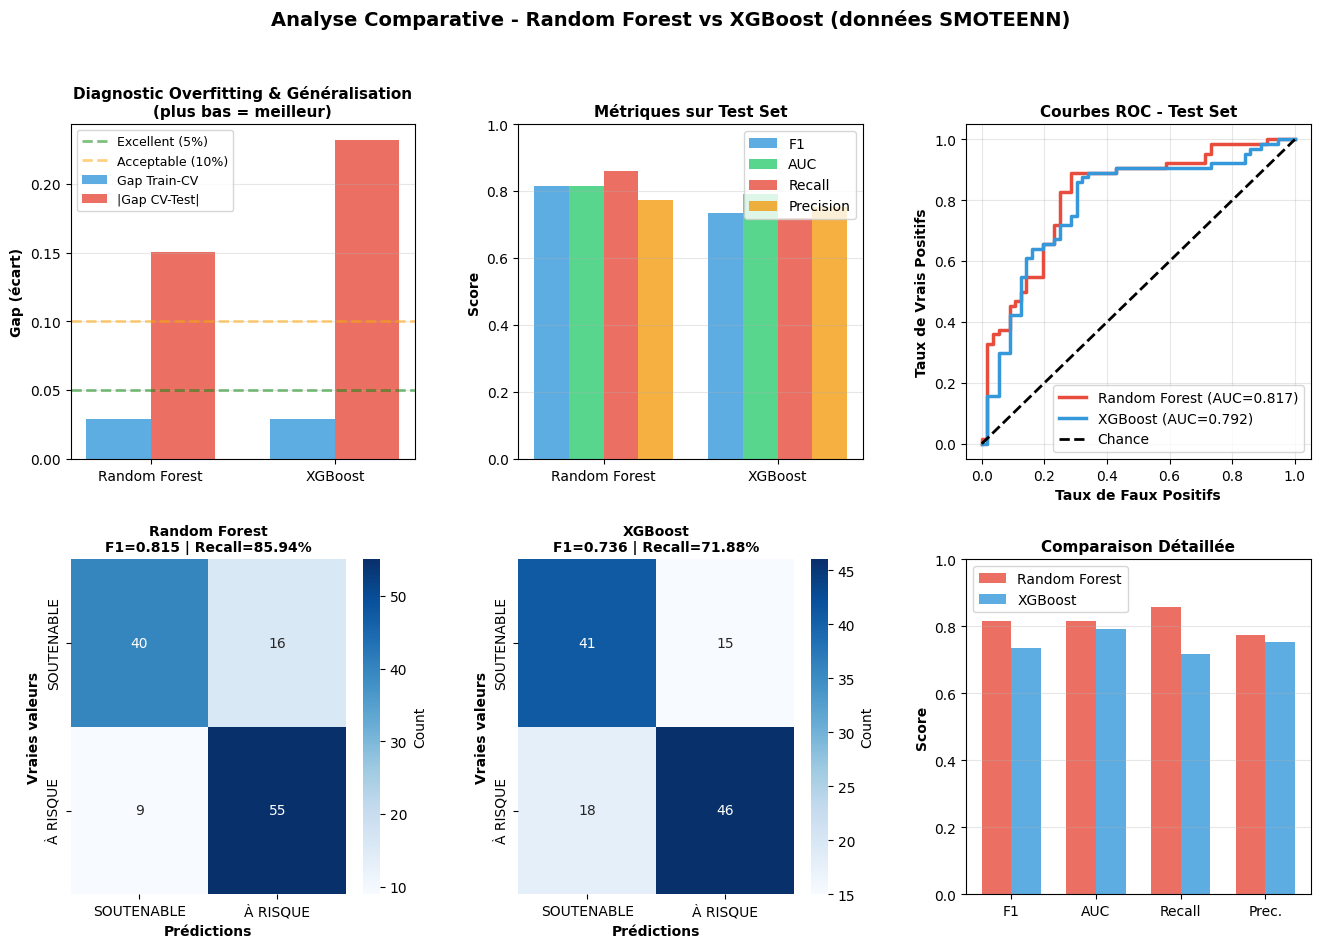


              precision    recall  f1-score   support

  SOUTENABLE     0.8163    0.7143    0.7619        56
    À RISQUE     0.7746    0.8594    0.8148        64

    accuracy                         0.7917       120
   macro avg     0.7955    0.7868    0.7884       120
weighted avg     0.7941    0.7917    0.7901       120


 Feature Importance:
              Feature  Importance
    External_Debt_GDP    0.219748
Corruption_Governance    0.196979
        Exchange_Rate    0.157292
 Debt_Service_Exports    0.135442
     Net_ODA_received    0.118809
           GDP_Growth    0.088195
      Current_Account    0.083535

 Le meilleure modèle: Random Forest
Gap CV-Test: 0.1501Problématique
AUC Test: 0.8167Excellente
Recall Test: 85.94%Excellente


In [46]:
# ======================================================================
# ÉVALUATION SUR TEST SET
# ======================================================================

models = {
    'Random Forest': bayes_rf.best_estimator_,
    'XGBoost': bayes_xgb.best_estimator_
}

results = []

for name, model in models.items():
    print(f"\n {name}:")

    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    accuracy = accuracy_score(y_test_binary, y_pred)
    precision = precision_score(y_test_binary, y_pred)
    recall = recall_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)

    cm = confusion_matrix(y_test_binary, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if name == 'Random Forest':
        cv_score = bayes_rf.best_score_
        gap = gap_rf
    else:
        cv_score = bayes_xgb.best_score_
        gap = gap_xgb

    test_gap = cv_score - f1

    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1:        {f1:.4f}")
    print(f"   AUC:       {auc:.4f}")
    print(f"   Confusion: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    print(f"   Gap CV-Test: {test_gap:.4f}", end="")
    if abs(test_gap) < 0.05:
        print("Excellent")
    elif abs(test_gap) < 0.10:
        print("Acceptable")
    else:
        print("Écart important")

    results.append({
        'Modèle': name,
        'CV_Score': cv_score,
        'CV_Gap': gap,
        'Test_F1': f1,
        'Test_AUC': auc,
        'Test_Recall': recall,
        'Test_Precision': precision,
        'Test_Accuracy': accuracy,
        'CV_Test_Gap': test_gap,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    })

results_df = pd.DataFrame(results)

# ======================================================================
# TABLEAU COMPARATIF
# ======================================================================

print("\n" + "="*70)
print("TABLEAU COMPARATIF COMPLET")
print("="*70)
print(results_df[['Modèle', 'CV_Score', 'CV_Gap', 'Test_F1', 'Test_AUC',
                  'Test_Recall', 'Test_Precision', 'CV_Test_Gap']].to_string(index=False))

print("   • CV_Gap: Écart Train-CV (overfitting interne)")
print("   • CV_Test_Gap: Écart CV-Test final (généralisation)")
print("   • |CV_Test_Gap| < 0.05 = Excellent")
print("   • |CV_Test_Gap| < 0.10 = Acceptable")

# Identifier le meilleur modèle
best_model_name = results_df.loc[results_df['Test_F1'].idxmax(), 'Modèle']
best_model_row = results_df.loc[results_df['Test_F1'].idxmax()]

print(f"\n Meilleur modèle (F1 Test): {best_model_name}")
print(f"   Test F1: {best_model_row['Test_F1']:.4f}")
print(f"   Test AUC: {best_model_row['Test_AUC']:.4f}")
print(f"   Test Recall: {best_model_row['Test_Recall']:.2%}")
print(f"   Gap CV-Test: {best_model_row['CV_Test_Gap']:.4f}")

# ======================================================================
# VISUALISATIONS
# ======================================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
x_pos = np.arange(len(results_df))
width = 0.35

ax.bar(x_pos - width/2, results_df['CV_Gap'], width,
       label='Gap Train-CV', alpha=0.8, color='#3498db')
ax.bar(x_pos + width/2, np.abs(results_df['CV_Test_Gap']), width,
       label='|Gap CV-Test|', alpha=0.8, color='#e74c3c')

ax.axhline(y=0.05, color='green', linestyle='--', lw=2, alpha=0.5,
           label='Excellent (5%)')
ax.axhline(y=0.10, color='orange', linestyle='--', lw=2, alpha=0.5,
           label='Acceptable (10%)')

ax.set_ylabel('Gap (écart)', fontweight='bold')
ax.set_title('Diagnostic Overfitting & Généralisation\n(plus bas = meilleur)',
             fontweight='bold', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Modèle'])
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

ax = fig.add_subplot(gs[0, 1])
metrics = ['Test_F1', 'Test_AUC', 'Test_Recall', 'Test_Precision']
x = np.arange(len(results_df))
width = 0.2

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for i, (metric, color) in enumerate(zip(metrics, colors)):
    offset = (i - len(metrics)/2) * width + width/2
    ax.bar(x + offset, results_df[metric], width,
           label=metric.replace('Test_', ''), alpha=0.8, color=color)

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Métriques sur Test Set', fontweight='bold', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Modèle'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])


ax = fig.add_subplot(gs[0, 2])
colors_roc = ['#e74c3c', '#3498db']
for (name, model), color in zip(models.items(), colors_roc):
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    auc_score = results_df[results_df['Modèle']==name]['Test_AUC'].values[0]
    ax.plot(fpr, tpr, lw=2.5, label=f'{name} (AUC={auc_score:.3f})', color=color)

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
ax.set_xlabel('Taux de Faux Positifs', fontweight='bold')
ax.set_ylabel('Taux de Vrais Positifs', fontweight='bold')
ax.set_title('Courbes ROC - Test Set', fontweight='bold', fontsize=11)
ax.legend()
ax.grid(alpha=0.3)


for idx, (name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[1, idx])

    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test_binary, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['SOUTENABLE', 'À RISQUE'],
                yticklabels=['SOUTENABLE', 'À RISQUE'],
                ax=ax, cbar_kws={'label': 'Count'})

    f1_val = results_df[results_df['Modèle']==name]['Test_F1'].values[0]
    recall_val = results_df[results_df['Modèle']==name]['Test_Recall'].values[0]

    ax.set_xlabel('Prédictions', fontweight='bold')
    ax.set_ylabel('Vraies valeurs', fontweight='bold')
    ax.set_title(f'{name}\nF1={f1_val:.3f} | Recall={recall_val:.2%}',
                 fontsize=10, fontweight='bold')


ax = fig.add_subplot(gs[1, 2])

categories = ['F1', 'AUC', 'Recall', 'Prec.']
rf_scores = [results_df[results_df['Modèle']=='Random Forest']['Test_F1'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_AUC'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_Recall'].values[0],
             results_df[results_df['Modèle']=='Random Forest']['Test_Precision'].values[0]]

xgb_scores = [results_df[results_df['Modèle']=='XGBoost']['Test_F1'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_AUC'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_Recall'].values[0],
              results_df[results_df['Modèle']=='XGBoost']['Test_Precision'].values[0]]

x = np.arange(len(categories))
width = 0.35

ax.bar(x - width/2, rf_scores, width, label='Random Forest',
       alpha=0.8, color='#e74c3c')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost',
       alpha=0.8, color='#3498db')

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Comparaison Détaillée', fontweight='bold', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.suptitle('Analyse Comparative - Random Forest vs XGBoost (données SMOTEENN)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ======================================================================
# RAPPORT DÉTAILLÉ MEILLEUR MODÈLE
# ======================================================================

best_model = models[best_model_name]
y_pred_final = best_model.predict(X_test_final)

print("\n" + classification_report(y_test_binary, y_pred_final,
                                   target_names=['SOUTENABLE', 'À RISQUE'],
                                   digits=4))

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    print("\n Feature Importance:")
    importances = best_model.feature_importances_
    feature_imp_df = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_imp_df.to_string(index=False))

# ======================================================================
# VERDICT FINAL
# ======================================================================


print(f"\n Le meilleure modèle: {best_model_name}")

print(f"Gap CV-Test: {best_model_row['CV_Test_Gap']:.4f}", end="")
if abs(best_model_row['CV_Test_Gap']) < 0.05:
    print("Excellente")
elif abs(best_model_row['CV_Test_Gap']) < 0.10:
    print("Acceptable")
else:
    print("Problématique")

print(f"AUC Test: {best_model_row['Test_AUC']:.4f}", end="")
if best_model_row['Test_AUC'] >= 0.80:
    print("Excellente")
elif best_model_row['Test_AUC'] >= 0.75:
    print("Bonne")
elif best_model_row['Test_AUC'] >= 0.70:
    print("Acceptable")
else:
    print("Insuffisante")

print(f"Recall Test: {best_model_row['Test_Recall']:.2%}", end="")
if best_model_row['Test_Recall'] >= 0.75:
    print("Excellente")
elif best_model_row['Test_Recall'] >= 0.65:
    print("Acceptable")
else:
    print("Trop de cas ratés")
